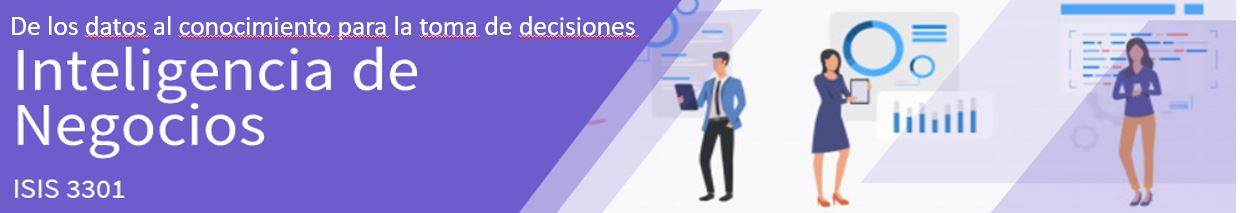

## Agrupamiento por similitud

Para el negocio es necesario entender las características de los grupos de senderos, para esto se debe implementar un algoritmo de agrupación por similitud (k-means), agrupando las mejores características para poder promocionar el turismo a estos senderos:
1. Carga de librerías necesarias para implementación.
2. Cargar los datos.
3. Perfilamiento, entendimiento y limpieza de los datos.
4. Implementación de k-means.
5. Concluir para dar una respuesta a la empresa.

## 1. Carga de librerías necesarias para implementación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots


## 2. Cargar los datos

In [2]:
# Se cargan los datos. 
df_rutas=pd.read_excel('CalidadRutasIrlanda2.xlsx')

## 3. Perfilamiento, entendimiento y limpieza de los datos 

In [3]:
df_rutas.shape

(872, 17)

In [4]:
df_rutas.head()

,trail_id,trail_name,county,category,rating,type,format,length_km,climb_m,grade,estimated_time_to_complete_mins,dogs_allowed,description_of_waymarking,nearest_town_to_start,start_point,finish_point,nearest_town_to_finish
0,1,Ballyhoura Way,"Cork, Limerick, Tipperary",1.0,**,National Waymarked Trail,Linear,89.0,1560,Moderate,5760.0,1.0,Yellow arrow on black background,Kanturk,St.Johns Bridge,Limerick Junction,Tipperary
1,2,Barrow Way,"Kildare, Laois, Carlow",1.0,**,National Waymarked Trail,Linear,100.0,0,Easy,5760.0,1.0,Yellow arrow on black background,Robertstown,Robertstown,St. Mullins,Graiguenamanagh
2,3,Beara Way,"Cork, Kerry",1.0,**,National Waymarked Trail,Loop,206.0,5245,Strenuous,12960.0,0.0,Yellow arrow on black background,Glengarriff,Glengarriff,Glengarriff,Glengarriff
3,4,Blackwater Way - Avondhu,"Cork, Tipperary",1.0,***,National Waymarked Trail,Linear,94.0,3690,Moderate,10080.0,0.0,Yellow arrow on black background,Clogheen,Clogheen,Bweeng,Mallow
4,5,Blackwater Way - Duhallow,"Cork, Kerry",1.0,**,National Waymarked Trail,Linear,67.0,NaN,Moderate,4320.0,0.0,Yellow arrow on black background,Mallow,Bweeng,Shrone,Rathmore


In [5]:
# Revisar las características de los datos: completitud y tipo de dato
df_rutas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   trail_id                         872 non-null    int64  
 1   trail_name                       872 non-null    object 
 2   county                           872 non-null    object 
 3   category                         867 non-null    float64
 4   rating                           628 non-null    object 
 5   type                             861 non-null    object 
 6   format                           852 non-null    object 
 7   length_km                        858 non-null    float64
 8   climb_m                          688 non-null    object 
 9   grade                            816 non-null    object 
 10  estimated_time_to_complete_mins  831 non-null    float64
 11  dogs_allowed                     532 non-null    float64
 12  description_of_waymark

In [6]:
# Se debe corregir la columna climb ya que tiene datos variados
df_rutas['climb_m'].fillna("0", inplace = True)
df_rutas['climb_m'].replace({"40m": "40", "Minimal": "0", "10m": "10", "None": "0"}, inplace=True)
df_rutas['climb_m']=df_rutas['climb_m'].astype(float)
df_rutas.dtypes

trail_id                             int64
trail_name                          object
county                              object
category                           float64
rating                              object
type                                object
format                              object
length_km                          float64
climb_m                            float64
grade                               object
estimated_time_to_complete_mins    float64
dogs_allowed                       float64
description_of_waymarking           object
nearest_town_to_start               object
start_point                         object
finish_point                        object
nearest_town_to_finish              object
dtype: object

In [7]:
# Resumen de los estadisticos de las variables numéricas
df_rutas.describe()

,trail_id,category,length_km,climb_m,estimated_time_to_complete_mins,dogs_allowed
count,872.000000,867.000000,858.000000,872.000000,831.000000,532.000000
mean,635.775229,2.235294,15.670478,137.538417,352.016847,0.776316
std,462.726942,2.241226,56.720700,396.316240,1314.289877,0.417105
min,1.000000,1.000000,0.200000,0.000000,10.000000,0.000000
25%,251.750000,1.000000,3.000000,0.000000,54.500000,1.000000
50%,605.500000,1.000000,5.100000,30.000000,90.000000,1.000000
75%,1013.250000,3.000000,10.000000,140.000000,150.000000,1.000000
max,4005.000000,8.000000,1400.000000,5310.000000,12960.000000,1.000000


In [8]:
#Separación de la variable duración (int) de variables float para ver mejor su contenido dada la diferencia de magnitudes en el dominio
name_cols_float = df_rutas.select_dtypes(include = ['float']).columns
name_cols_int = df_rutas.select_dtypes(include = ['int64']).columns
print(name_cols_int)
print(name_cols_float)
# No se toma en cuenta la columna trail_id ya que es solo un identificador.

Index(['trail_id'], dtype='object')
Index(['category', 'length_km', 'climb_m', 'estimated_time_to_complete_mins',
       'dogs_allowed'],
      dtype='object')


In [9]:
# Se revisan la cantidad de nulos en las columnas numéricas
df_rutas[name_cols_float].isnull().sum()

category                             5
length_km                           14
climb_m                              0
estimated_time_to_complete_mins     41
dogs_allowed                       340
dtype: int64

In [10]:
# Se corrige la columna dogs_allowed asumiendo que los vacios son 0, es decir, no permitido
df_rutas['dogs_allowed'].fillna('0', inplace = True)
df_rutas['dogs_allowed']=df_rutas['dogs_allowed'].astype(int)
df_rutas.dogs_allowed.dtype

dtype('int32')

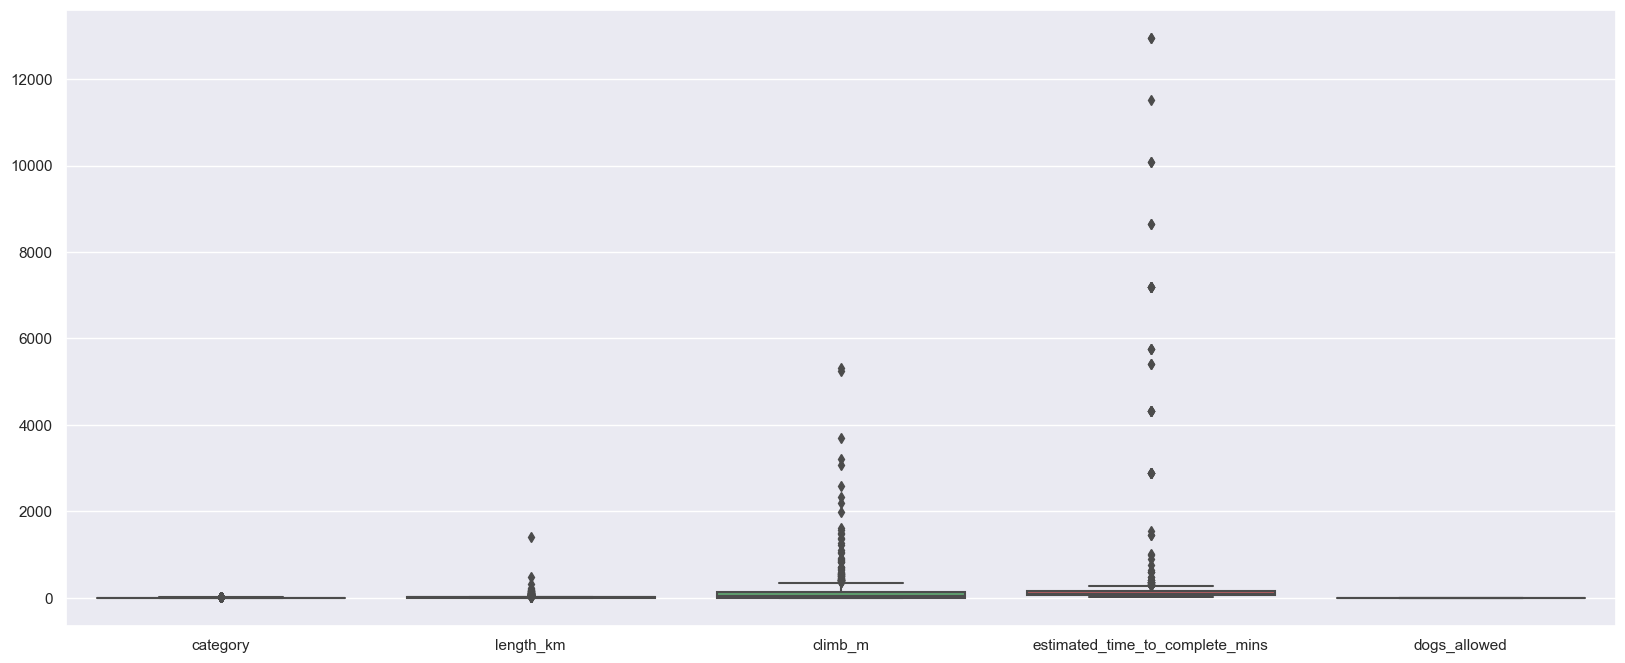

In [11]:
#Visualización de todas las variables numéricas
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_rutas[name_cols_float], orient="v")
plt.show()

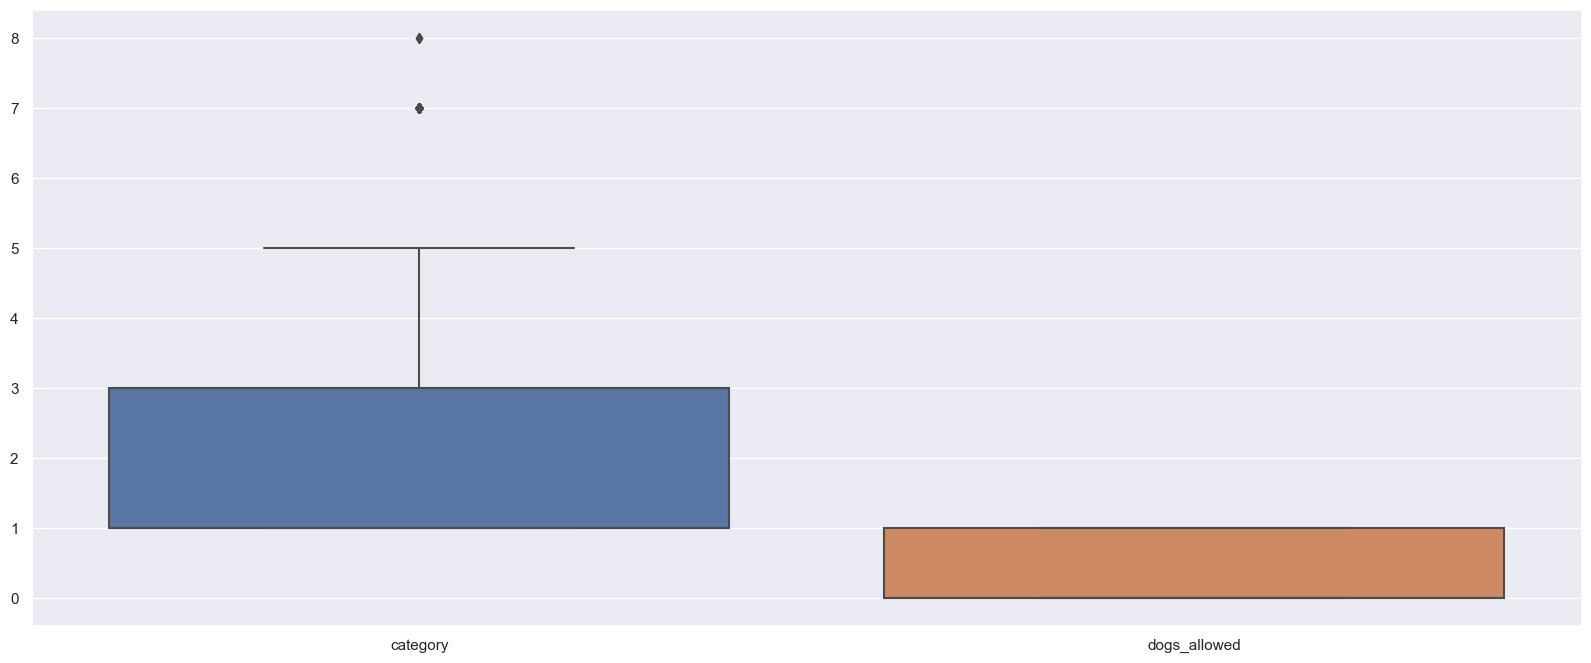

In [12]:
#Visualización de todas las variables numéricas
name_cols_float = name_cols_float.drop('length_km')
name_cols_float = name_cols_float.drop('climb_m')
name_cols_float = name_cols_float.drop('estimated_time_to_complete_mins')
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_rutas[name_cols_float], orient="v")
plt.show()

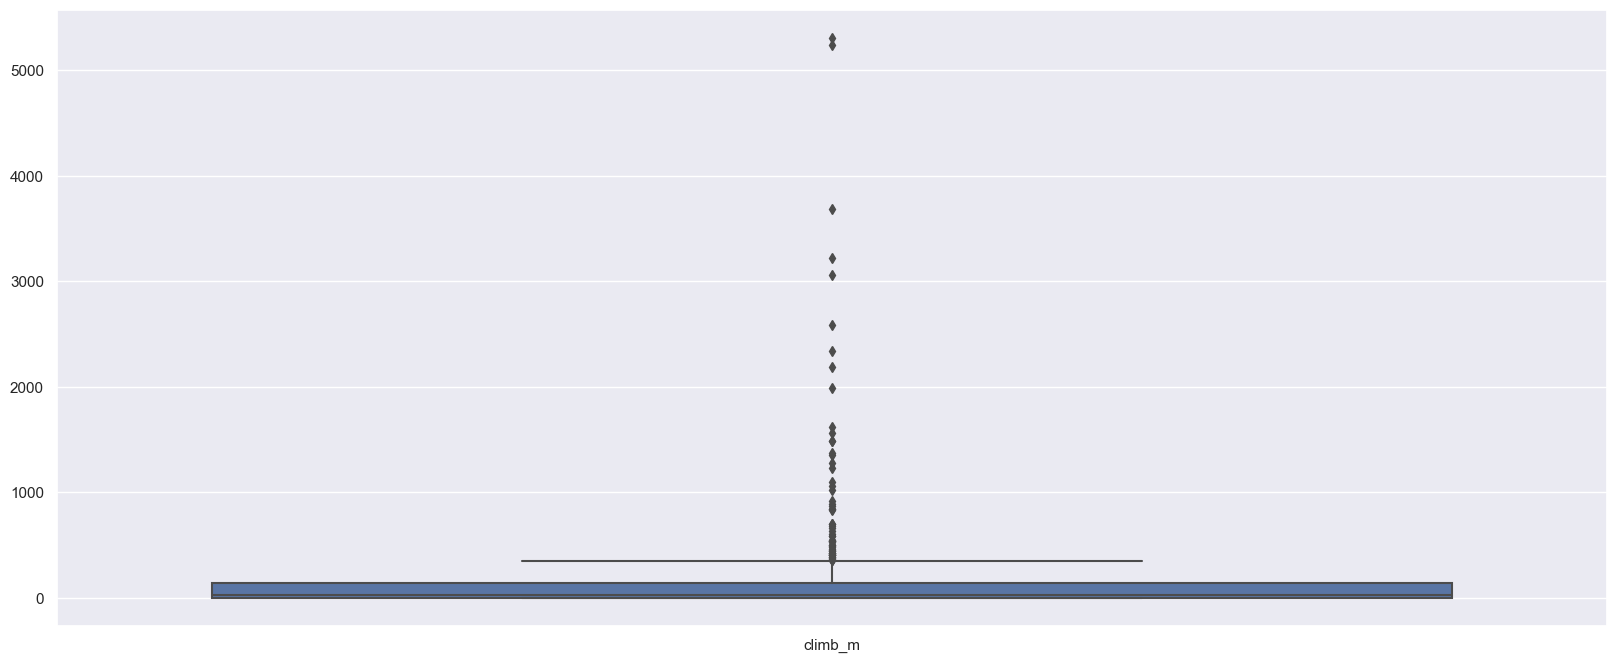

In [13]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df_rutas[['climb_m']], orient="v")
plt.show()

In [14]:
# Explorar las variables que no son numéricas
name_cols_non_number = df_rutas.select_dtypes(include = ['object']).columns
name_cols_non_number

Index(['trail_name', 'county', 'rating', 'type', 'format', 'grade',
       'description_of_waymarking', 'nearest_town_to_start', 'start_point',
       'finish_point', 'nearest_town_to_finish'],
      dtype='object')

In [15]:
# Se revisan los nulos que hayan en los datos no numéricos
df_rutas[name_cols_non_number].isnull().sum()

trail_name                     0
county                         0
rating                       244
type                          11
format                        20
grade                         56
description_of_waymarking    445
nearest_town_to_start         18
start_point                  190
finish_point                 189
nearest_town_to_finish       411
dtype: int64

In [16]:
# Revisamos el contenido de la columna type
df_rutas.type.sample(10)

461                        Other
306           National Loop Walk
579                        Other
175    Coillte Recreation Trails
186    Coillte Recreation Trails
657                    Sli Route
319    Coillte Recreation Trails
76            National Loop Walk
827                      Cycling
816                      Cycling
Name: type, dtype: object

In [17]:
# Revisamos el contenido de la columna format
df_rutas.format.sample(10)

688    Circular
772    Circular
550      Linear
794    Circular
637    Circular
531      Linear
250      Access
619    Circular
734    Circular
815    Circular
Name: format, dtype: object

In [18]:
# Revisamos el contenido de la columna grade
df_rutas.grade.sample(10)

836          NaN
115     Moderate
17          Easy
190    Strenuous
502         Easy
421         Easy
690         Easy
235         Easy
646         Easy
440    Strenuous
Name: grade, dtype: object

In [19]:
# Revisamos el contenido de la columna description_of_waymarking
df_rutas.description_of_waymarking.sample(10)

688                                NaN
625    Green arrow on white background
479                                NaN
224                      Yellow arrows
391                          Red arrow
739                                NaN
301                                NaN
498      Red arrow on white background
658                                NaN
215                                NaN
Name: description_of_waymarking, dtype: object

In [20]:
#Revisar el contenido de las variables que no son numéricas
df_rutas[name_cols_non_number].describe()

,trail_name,county,rating,type,format,grade,description_of_waymarking,nearest_town_to_start,start_point,finish_point,nearest_town_to_finish
count,872,872,628,861,852,816,427,854,682,683,461
unique,852,44,3,16,12,26,80,385,411,414,238
top,Royal Canal Greenway - Westmeath,Cork,***,National Loop Walk,Circular,Easy,Yellow arrow on black background,Laragh,Car Park,Car Park,Cloghan
freq,2,126,536,195,676,422,52,12,21,21,9


## 4. Implementación de k-means

### 4.1 Identificar las variables a utilizar 
Este algoritmo solo trabaja con datos numéricos, por lo tanto, seleccionamos todas las variables numéricas.

In [21]:
name_cols_number = df_rutas.select_dtypes(include = ['float', 'int32']).columns #Todas las numéricas
name_cols_number

Index(['category', 'length_km', 'climb_m', 'estimated_time_to_complete_mins',
       'dogs_allowed'],
      dtype='object')

### 4.2 Transformar los datos
Y se decide que vamos a transformar algunas variables no numéricas para utilizar.

Estas son format y grade.

In [22]:
ind = pd.Index(['grade', 'format'])
name_cols_number = name_cols_number.append(ind)
name_cols_number

Index(['category', 'length_km', 'climb_m', 'estimated_time_to_complete_mins',
       'dogs_allowed', 'grade', 'format'],
      dtype='object')

In [23]:
# Se revisa la cantidad de datos únicos en la columna format y se hace una copia de estos datos
df_trans = df_rutas[name_cols_number].copy()
df_trans.format.value_counts()

Circular                                 676
Linear                                   154
Loop                                       6
Linear / Circular                          3
Linear + Circular                          2
2 Circulars                                2
Access                                     2
Out and back                               2
Circular / Linear depending on route.      2
Linear and Circular                        1
Circular/Linear                            1
Circular / Linear                          1
Name: format, dtype: int64

In [24]:
# Se decide llenar los datos vacios con la moda, agrupar datos similares y agrupar datos poco comunes en los generales 
# según la definición del camino.
df_trans['format'].fillna("Circular", inplace = True)
df_trans['format'].replace({"Circular / Linear": "Circular/Linear", "Circular / Linear depending on route.":
                            "Circular/Linear","Linear + Circular": "Circular/Linear","Linear / Circular": 
                            "Circular/Linear","Linear and Circular": "Circular/Linear"}, inplace=True)
df_trans['format'].replace({"Out and back": "Circular/Linear","Access": "Linear","2 Circulars": "Circular",
                            "Loop": "Circular"}, inplace=True)
df_trans.format.value_counts()

Circular           704
Linear             156
Circular/Linear     12
Name: format, dtype: int64

In [25]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def trail_format (row):
    if row['format'] == 'Circular' :
        return 1
    elif row['format'] == 'Linear' :
        return 2
    return 3
df_trans['trail_format']=df_trans.apply (lambda row: trail_format(row), axis=1)   
df_trans.head()

,category,length_km,climb_m,estimated_time_to_complete_mins,dogs_allowed,grade,format,trail_format
0,1.0,89.0,1560.0,5760.0,1,Moderate,Linear,2
1,1.0,100.0,0.0,5760.0,1,Easy,Linear,2
2,1.0,206.0,5245.0,12960.0,0,Strenuous,Circular,1
3,1.0,94.0,3690.0,10080.0,0,Moderate,Linear,2
4,1.0,67.0,0.0,4320.0,0,Moderate,Linear,2


In [26]:
# Se revisa la cantidad de datos únicos en la columna grade
df_trans.grade.value_counts()

Easy                                    422
Moderate                                262
Strenuous                                43
Buggy and wheelchair friendly            19
Hard                                     19
Challenging                              10
Difficult                                 7
Easy - buggy and wheelchair friendly      7
Moderate-Difficult                        3
Very challenging                          3
Easy/Moderate                             3
Severe                                    3
Multi-Access/Easy                         2
Intermediate                              1
Beginner                                  1
Very Challenging                          1
Family                                    1
Difficult Severe                          1
Stenuous                                  1
Moderately Strenuous                      1
Moderate - Hard                           1
Very Difficult                            1
Mod                             

In [27]:
# Se decide llenar los datos vacios con la moda y agrupar datos similares (Fácil, Moderado, Dificil y Amigable).
df_trans['grade'].fillna("Easy", inplace = True)
df_trans['grade'].replace({"Easy/Moderate": "Easy", "Multi-Access/Easy": "Easy","Beginner": "Easy","Family": "Easy"
                          ,"Easy- Moderate": "Easy","Esay": "Easy"}, inplace=True)
df_trans['grade'].replace({"Moderate-Difficult": "Moderate","Intermediate": "Moderate","Moderate - Hard": "Moderate"
                          ,"Mod": "Moderate"}, inplace=True)
df_trans['grade'].replace({"Strenuous": "Hard","Challenging": "Hard","Difficult": "Hard","Very challenging": "Hard",
                           "Severe": "Hard","Very Challenging": "Hard","Difficult Severe": "Hard","Stenuous": "Hard"
                          ,"Moderately Strenuous": "Hard","Very Difficult": "Hard","Advanced": "Hard"}, inplace=True)
df_trans['grade'].replace({"Easy - buggy and wheelchair friendly": "Buggy and wheelchair friendly",
                           "2 Circulars": "Buggy and wheelchair friendly"}, inplace=True)
df_trans.grade.value_counts()

Easy                             487
Moderate                         268
Hard                              91
Buggy and wheelchair friendly     26
Name: grade, dtype: int64

In [28]:
# Ahora definimos la función que nos va a permitir construir nuestra clase.
def difficulty (row):
    dif = row['grade']
    if dif == 'Easy' :
        return 1
    elif dif == 'Moderate' :
        return 2
    elif dif == 'Hard' :
        return 3
    return 0
df_trans['difficulty']=df_trans.apply (lambda row: difficulty(row), axis=1)   
df_trans.head()

,category,length_km,climb_m,estimated_time_to_complete_mins,dogs_allowed,grade,format,trail_format,difficulty
0,1.0,89.0,1560.0,5760.0,1,Moderate,Linear,2,2
1,1.0,100.0,0.0,5760.0,1,Easy,Linear,2,1
2,1.0,206.0,5245.0,12960.0,0,Hard,Circular,1,3
3,1.0,94.0,3690.0,10080.0,0,Moderate,Linear,2,2
4,1.0,67.0,0.0,4320.0,0,Moderate,Linear,2,2


### 4.3 Preparar los datos

In [29]:
df_prep = df_trans.copy()
df_prep.drop('grade', axis=1, inplace=True)
df_prep.drop('format', axis=1, inplace=True)
df_prep.head()

,category,length_km,climb_m,estimated_time_to_complete_mins,dogs_allowed,trail_format,difficulty
0,1.0,89.0,1560.0,5760.0,1,2,2
1,1.0,100.0,0.0,5760.0,1,2,1
2,1.0,206.0,5245.0,12960.0,0,1,3
3,1.0,94.0,3690.0,10080.0,0,2,2
4,1.0,67.0,0.0,4320.0,0,2,2


In [30]:
# Se verifican los valores nulos en los datos
df_prep.isnull().sum()

category                            5
length_km                          14
climb_m                             0
estimated_time_to_complete_mins    41
dogs_allowed                        0
trail_format                        0
difficulty                          0
dtype: int64

In [31]:
print(df_prep.category.value_counts().iloc[:1])
print(df_prep.length_km.value_counts().iloc[:1])
print(df_prep.estimated_time_to_complete_mins.value_counts().iloc[:1])

1.0    613
Name: category, dtype: int64
4.0    61
Name: length_km, dtype: int64
60.0    114
Name: estimated_time_to_complete_mins, dtype: int64


In [32]:
# Se decide cambiar ese dato por la moda
df_prep['category'].fillna("1.0", inplace = True)
df_prep['category']=df_prep['category'].astype(float)
df_prep['length_km'].fillna("4.0", inplace = True)
df_prep['length_km']=df_prep['length_km'].astype(float)
df_prep['estimated_time_to_complete_mins'].fillna("60.0", inplace = True)
df_prep['estimated_time_to_complete_mins']=df_prep['estimated_time_to_complete_mins'].astype(float)
df_prep.describe()

,category,length_km,climb_m,estimated_time_to_complete_mins,dogs_allowed,trail_format,difficulty
count,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000
mean,2.228211,15.483108,137.538417,338.286697,0.473624,1.206422,1.486239
std,2.236732,56.282144,396.316240,1284.473598,0.499590,0.437669,0.720246
min,1.000000,0.200000,0.000000,10.000000,0.000000,1.000000,0.000000
25%,1.000000,3.000000,0.000000,60.000000,0.000000,1.000000,1.000000
50%,1.000000,5.000000,30.000000,90.000000,0.000000,1.000000,1.000000
75%,3.000000,10.000000,140.000000,150.000000,1.000000,1.000000,2.000000
max,8.000000,1400.000000,5310.000000,12960.000000,1.000000,3.000000,3.000000


Lo siguiente es que se van a estandarizar los datos para evitar errores en el algoritmo

In [33]:
scaler = StandardScaler()
scaler.fit(df_prep)
X_scale = scaler.transform(df_prep)
df_scale = pd.DataFrame(X_scale, columns=df_prep.columns)
df_scale.head()

,category,length_km,climb_m,estimated_time_to_complete_mins,dogs_allowed,trail_format,difficulty
0,-0.549425,1.306970,3.591268,4.223384,1.054220,1.814231,0.713723
1,-0.549425,1.502526,-0.347241,4.223384,1.054220,1.814231,-0.675488
2,-0.549425,3.386975,12.894735,9.832010,-0.948568,-0.471910,2.102935
3,-0.549425,1.395859,8.968848,7.588559,-0.948568,1.814231,0.713723
4,-0.549425,0.915858,-0.347241,3.101658,-0.948568,1.814231,0.713723


### 4.4 Análisis de Componentes

In [34]:
pca = PCA(n_components=2)
pca.fit(df_scale)
pca_scale = pca.transform(df_scale)
pca_df = pd.DataFrame(pca_scale, columns=['pc1', 'pc2'])
print(abs( pca.components_ ))

[[0.2513732  0.33928897 0.55806241 0.52761531 0.30106464 0.09561787
  0.36345598]
 [0.5270867  0.27541526 0.15584532 0.32877112 0.45155545 0.43372838
  0.34917789]]


Se obtienen las principales 2 componentes y la influencia que cada variable tiene cada una.

Para la primera, las variables más importantes son: climb_m y estimated_time_to_complete_mins.

Para la segunda, las variables más importantes son: category y dogs_allowed.

### 4.5 Encontrar el número óptimo de clústeres utilizando el método del codo

In [35]:
def plot_distortion(data,
                    k_min=1, 
                    k_max=11,
                    ylabel = 'Distortion',
                    xlabel = 'Number of clusters',
                    title = 'Distortion Plot'):
    distortions = []
    for i in range(k_min, k_max):
        km = KMeans(n_clusters=i,
                 init='k-means++',
                 n_init=10,
                 max_iter=300,
                 random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    plt.plot(range(k_min,k_max), distortions, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

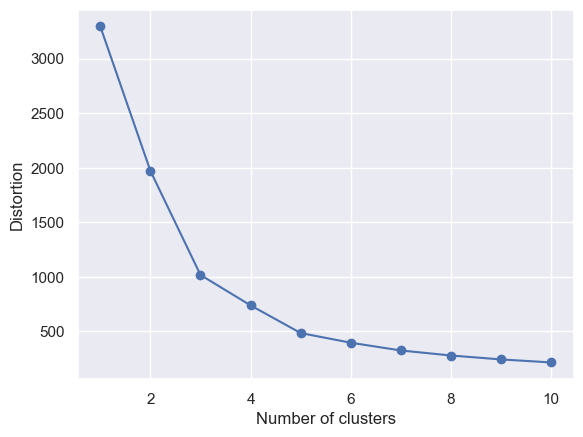

In [36]:
plot_distortion(pca_df)

Se define usar 3 clusters.

### 4.6 Construir el modelo

In [37]:
kmeans = KMeans(n_clusters=3, random_state=0) 
kmeans = kmeans.fit(pca_df)

In [38]:
#Transformar arreglo el dataframe que trabajamos para aplicar funciones más adelante.
cols_number = pca_df.to_numpy()
cols_number

array([[ 4.92951635,  3.03227974],
       [ 2.29301504,  2.95742252],
       [14.67564105,  4.51798478],
       ...,
       [-0.48762649,  1.05656201],
       [ 0.06607799,  0.60643148],
       [ 0.61375065,  0.15140467]])

### 4.7 Visualizar el resultado

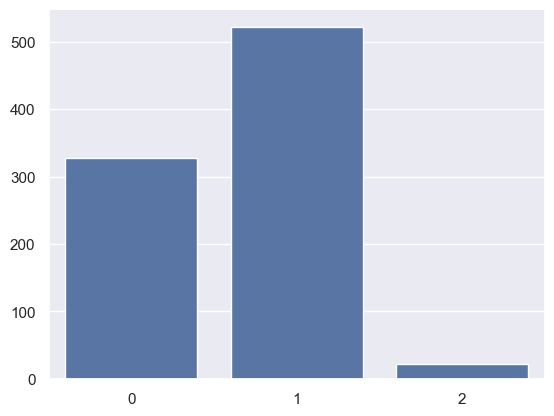

In [39]:
# Revisar la cantidad de registros en los clústeres resultado
labels = kmeans.labels_
pca_df['Cluster'] = labels

cluster_distrib = pca_df['Cluster'].value_counts()

fig=plt.figure()
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b');
plt.show()

In [40]:
# Revisar el número exacto de elementos por clúster y las variables utilizadas.
pca_df.groupby('Cluster').count()

,pc1,pc2
Cluster,,
0,328,328
1,522,522
2,22,22


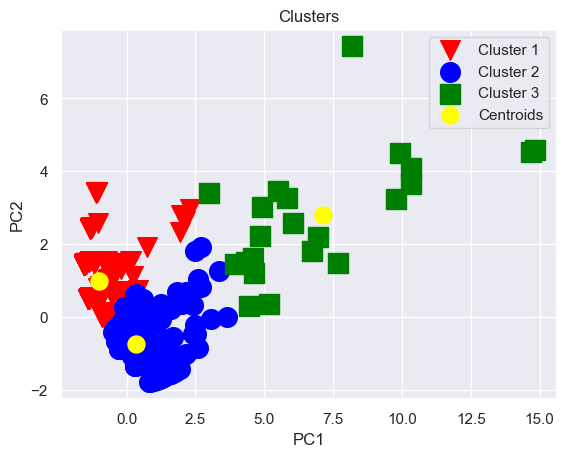

In [41]:
plt.scatter(cols_number[kmeans.labels_ == 0, 0], cols_number[kmeans.labels_ == 0, 1], s = 200, marker='v', c = 'red', label = 'Cluster 1')
plt.scatter(cols_number[kmeans.labels_ == 1, 0], cols_number[kmeans.labels_ == 1, 1], s = 200, marker='o', c = 'blue', label = 'Cluster 2')
plt.scatter(cols_number[kmeans.labels_ == 2, 0], cols_number[kmeans.labels_ == 2, 1], s = 200, marker='s', c = 'green', label = 'Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 150, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

Se muestra el agrupamiento basado en las principales variables.

In [42]:
# Revisemos los valores de los centroides de los clústeres generados
print('Centroides: [[','PC1', ' ' , 'PC2', ']]', kmeans.cluster_centers_)

Centroides: [[ PC1   PC2 ]] [[-1.0067181   0.98066215]
 [ 0.33247126 -0.73468898]
 [ 7.1206155   2.81138471]]


### 4.8 Evaluar la calidad de los clústeres obtenidos

In [43]:
#Creamos una función basada en el concepto de silueta
def plot_silhouette(data, 
                    labels,
                   ylabel = 'Clústeres',
                   xlabel = "Silhouette coefficient",
                   title = 'Silhouette Plot'):
    cluster_labels = np.unique(labels)
    print(cluster_labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data,
                                        labels,
                                        metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color="red",
                linestyle="--")
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

[0 1 2]


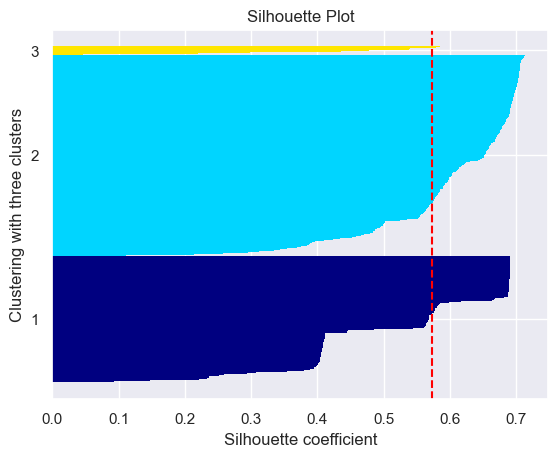

In [44]:
plot_silhouette(data = pca_df, 
                labels = kmeans.labels_, 
                ylabel = 'Clustering with three clusters')

No se tiene el mejor coeficiente de silueta sin embargo es aceptable.

### 4.9 Análisis y conclusiones

In [45]:
# Reunimos el dato de los clusters con los datos preparados para el modelo.
df_prep['Cluster'] = kmeans.labels_
df_prep

,category,length_km,climb_m,estimated_time_to_complete_mins,dogs_allowed,trail_format,difficulty,Cluster
0,1.0,89.0,1560.0,5760.0,1,2,2,2
1,1.0,100.0,0.0,5760.0,1,2,1,0
2,1.0,206.0,5245.0,12960.0,0,1,3,2
3,1.0,94.0,3690.0,10080.0,0,2,2,2
4,1.0,67.0,0.0,4320.0,0,2,2,1
...,...,...,...,...,...,...,...,...
867,1.0,2.0,10.0,30.0,1,1,1,0
868,2.0,2.0,10.0,15.0,0,1,1,1
869,5.0,2.0,0.0,60.0,0,2,1,0
870,5.0,6.0,0.0,120.0,0,2,2,0


In [46]:
# Finalmente se agrupan según el cluster para obtener las características principales de cada uno de los grupos.
df_prep.groupby('Cluster').mean()

,category,length_km,climb_m,estimated_time_to_complete_mins,dogs_allowed,trail_format,difficulty
Cluster,,,,,,,
0,3.768293,6.148780,14.666159,109.256098,0.926829,1.317073,0.969512
1,1.300766,13.557414,140.954023,198.180077,0.203065,1.120690,1.779693
2,1.272727,200.340909,1888.409091,7077.272727,0.136364,1.590909,2.227273


## 5. Concluir para dar una respuesta a la empresa

Se concluye que se deben establecer 3 grupos principales para promocionar el turismo de los senderos, tomando los datos numéricos más influyentes para tener este análisis. Esto permite identificar las características más comunes en los grupos que van a estos senderos.

El grupo 1 se trata de categorías geográficas de niveles altos, poca longitud (<8km), poca subida del terreno, tiempo estimado alrededor de las 2 horas, que permita perros, con un formato circular y una dificultad sencilla con acceso de discapacitados.

El grupo 2 se tiene categorías geográficas medianas, una longitud mediana (<15km), algo de elevación del terreno, en un tiempo de 3 horas o más, sin perros, con un formato circular y una dificultad moderada.

El grupo 3 tiene categorías geográficas medianas, con una mayor longitud y mayor elevación del terreno, gran tiempo para completar, sin perros, con un formato lineal y una dificultad moderada-dificil.